In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import scipy.stats
from tabulate import tabulate

In [2]:
df = pd.read_csv("../data/processed/trades_2025-10-01_to_2025-10-07_1min.csv")

In [3]:
class LCG:
    def __init__(self, seed=1, a=1664525, c=1013904223, m=2**32):
        self.x = seed % m
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.x = (self.a * self.x + self.c) % self.m
        return self.x
    
    def random(self):
        return self.next()

    def sample(self, n):
        output = []
        for _ in range(n):
            output.append(self.next())
        return output

In [4]:
class Unif(LCG):
    def __init__(self, a=0, b=1, seed=1, m=2**32):
        super().__init__(seed=seed, m=m)  # forward full LCG params
        self.low = a
        self.high = b
        self.m = m

    def next(self):
        x = super().next() / self.m
        # print(x*self.m)
        return self.low + (self.high - self.low) * x
    
    def random(self):
        return self.next()

    def sample(self, n):
        output = []
        for _ in range(n):
            output.append(self.next())
        return output

In [5]:
class Gamma(Unif):
    def __init__(self, k, theta=1, seed=1, m=2**32):
        super().__init__(seed=seed, m=m)
        if k <= 0 or theta <= 0:
            raise ValueError("k and theta must be > 0")
        self.k = int(k)
        self.theta = theta

    def next(self):
        total = 0
        for _ in range(self.k):
            u = super().next()
            total += -math.log(1 - u) * self.theta
        return total

    def sample(self, n):
        return [self.next() for _ in range(n)]

In [6]:
class Poisson(Unif):
    def __init__(self, lmda, seed=1, m=2**32):
        super().__init__(a=0, b=1, seed=seed, m=m)
        if lmda <= 0:
            raise ValueError("λ (lmda) must be > 0")
        self.lmda = lmda

    def next(self):
        L = math.exp(-self.lmda)
        k = 0
        p = 1.0

        while p > L:
            k += 1
            u = super().next()
            p *= u

        return k - 1

    def sample(self, n):
        return [self.next() for _ in range(n)]

In [7]:
class Gamma_Poisson:
    def __init__(self, alpha, beta, lag, df: pd.DataFrame):
        if alpha <= 0 or beta <= 0:
            raise ValueError("alpha and beta must be > 0")
        if lag <=0:
            raise ValueError("lag must be a Natural number")
            
        self.alpha = alpha
        self.beta = beta
        self.lag = (lag)
        self.df = df
        
        self.params = {"alpha":[alpha], "beta":[beta]}
        self.ppi = {}

    def generate_posterior(self):
        df = self.df
        df = df.sort_values(by="timestamp").reset_index(drop=True)
        array = df["trade_count"].tolist()
        alphas = []
        betas = []
        for i in range(len(array)):
            sum_counts = 0  
            upd_time = 0
            for j in range(max(0, i - self.lag + 1), i+1):
                sum_counts += array[j]
                upd_time = upd_time + 1

            alphas.append(sum_counts + self.alpha)
            betas.append(self.beta + upd_time)

        self.params["alpha"] = alphas
        self.params["beta"] = betas
    
    def generate_ppi(self, percent):
        ppis = {"lower_bound":[], "upper_bound":[]}
        percent = 1 - percent
        for alpha, beta in zip(self.params["alpha"][0:], self.params["beta"][0:]):
            r = alpha
            p = beta / (beta + 1)

            lb = scipy.stats.nbinom.ppf(percent / 2, r, p)
            ub = scipy.stats.nbinom.ppf(1 - percent / 2, r, p)
            ppis["lower_bound"].append(lb)
            ppis["upper_bound"].append(ub)

        self.ppi[1 - percent] = ppis

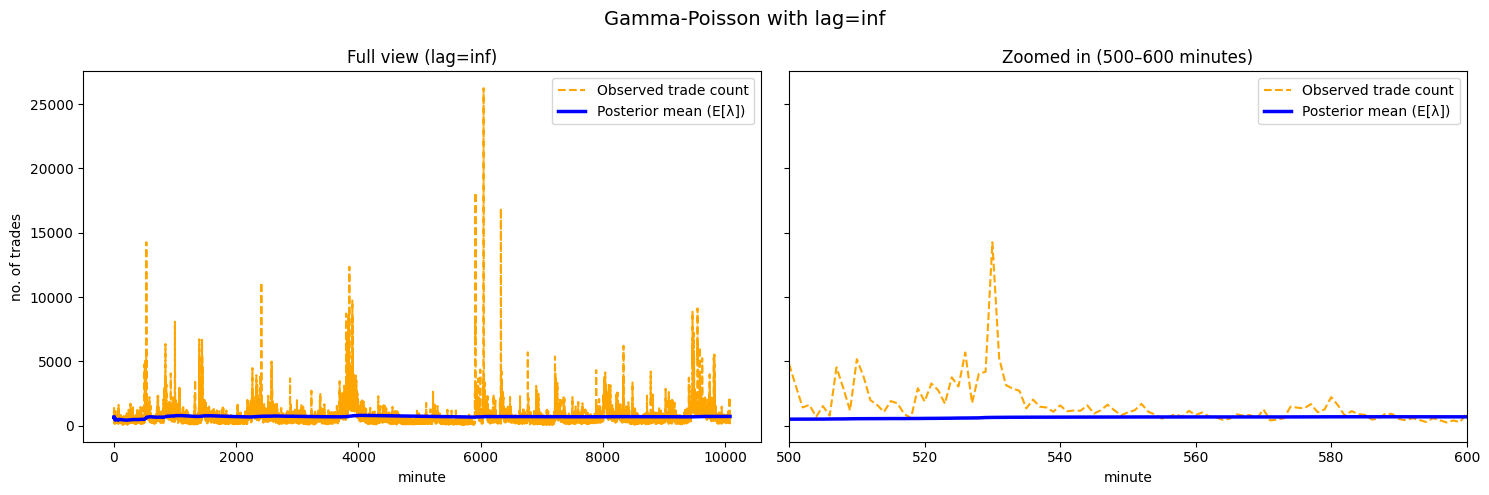

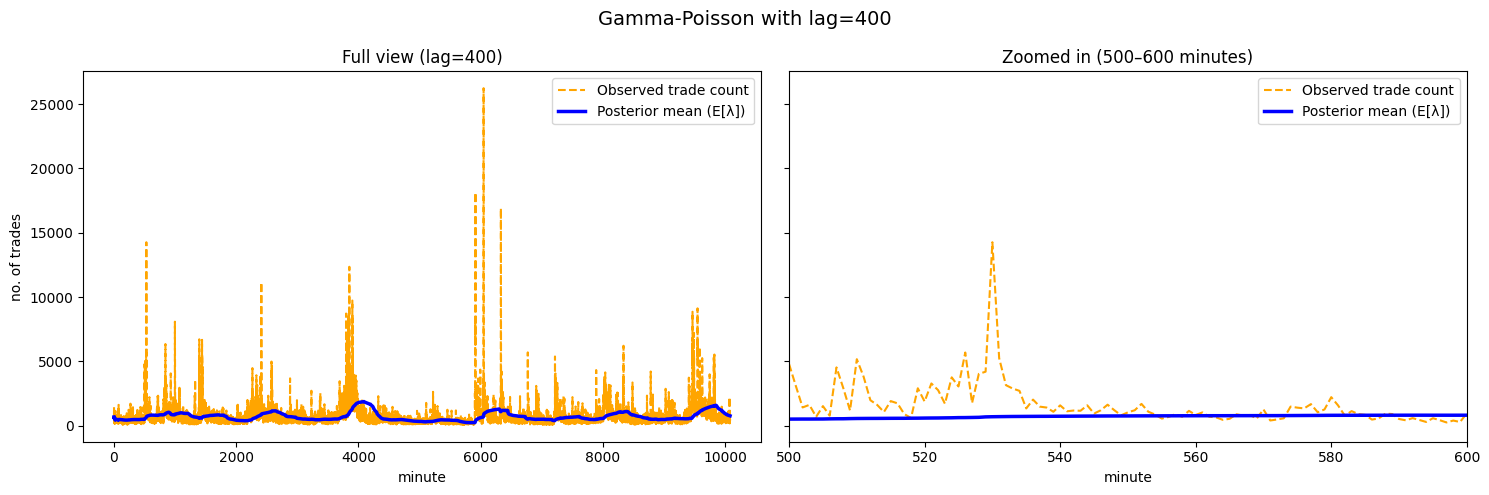

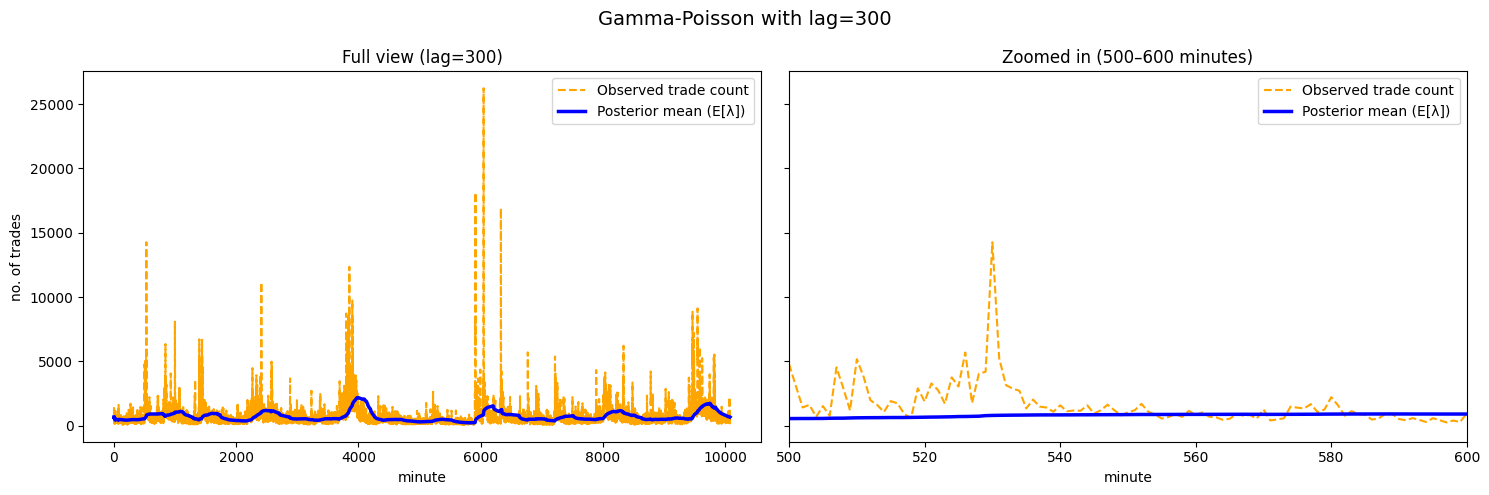

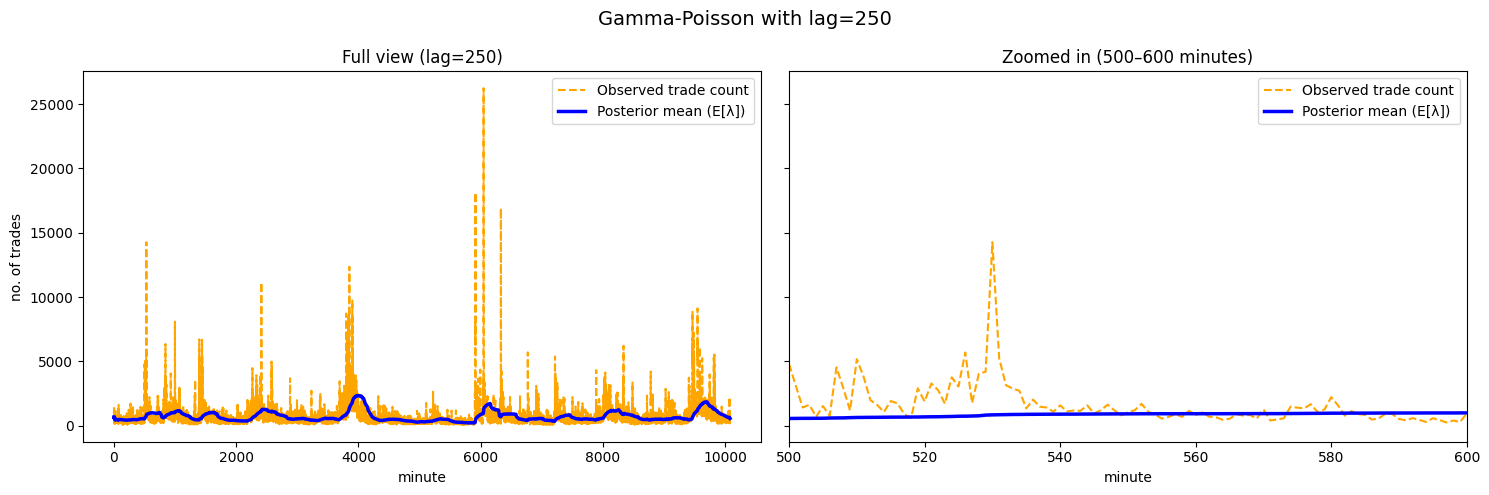

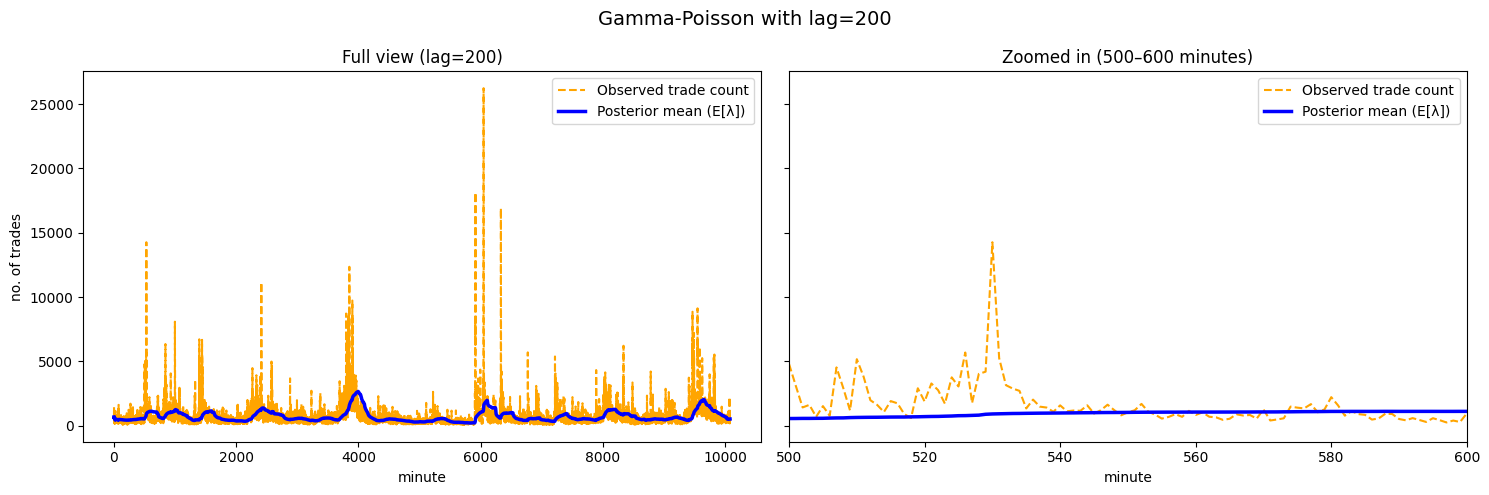

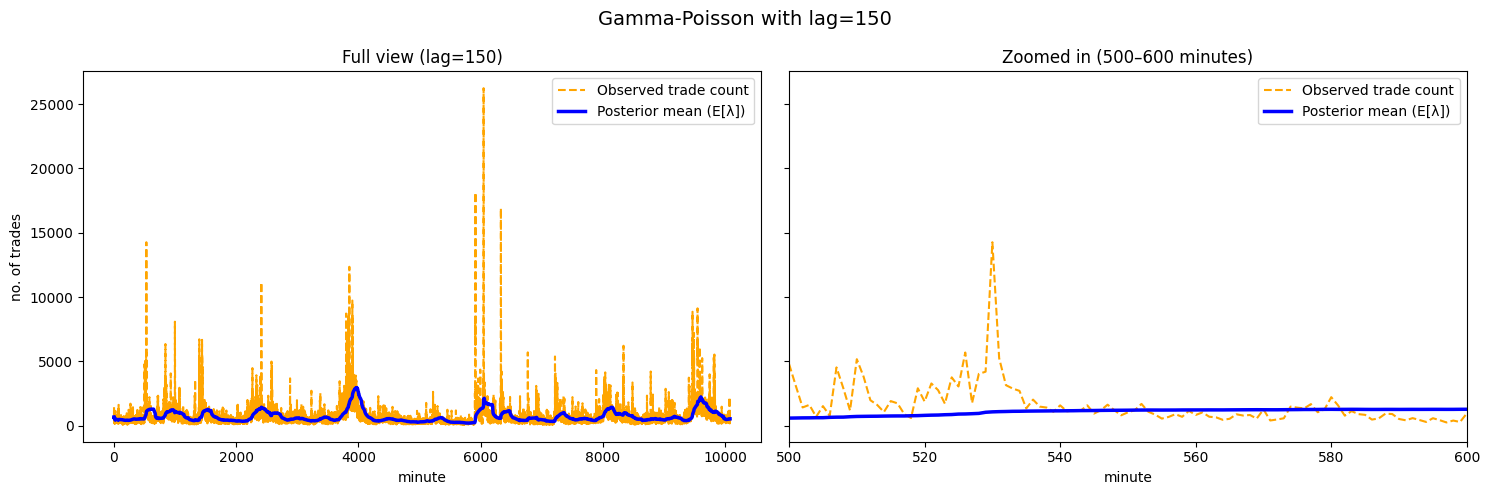

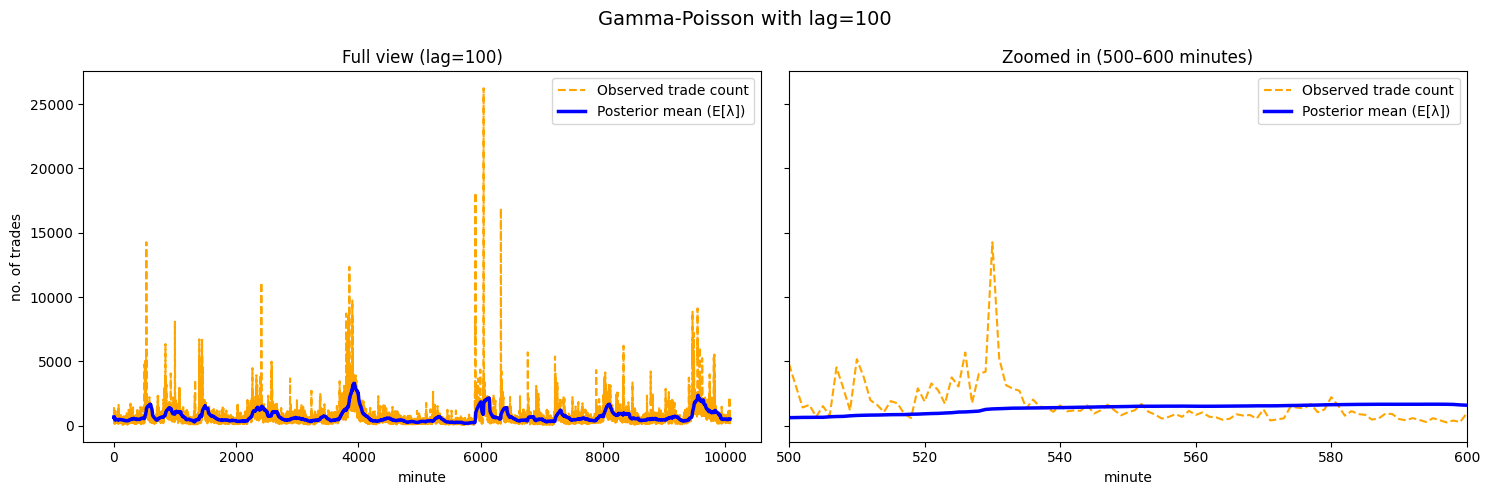

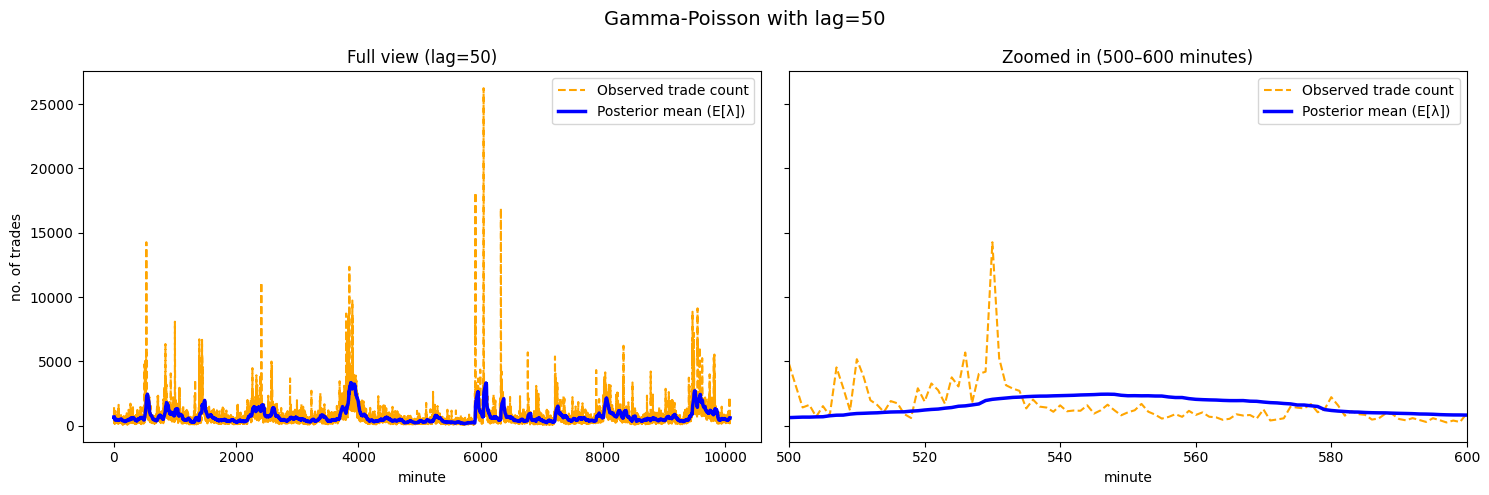

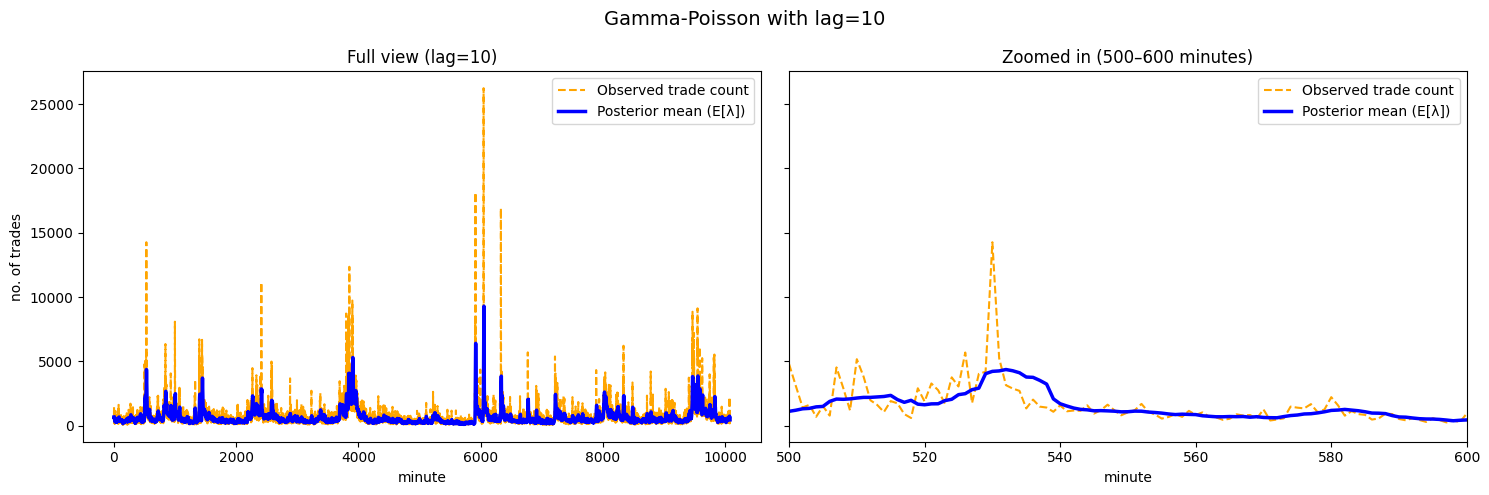

In [13]:
def expected_lambda(params, lag, zoom_start=0, zoom_end=200):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    lmda = [alpha / beta for alpha, beta in zip(params["alpha"][1:], params["beta"][1:])]
    x = range(len(df["trade_count"].values))

    # --- Left: Full plot ---
    axs[0].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[0].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[0].set_title(f"Full view (lag={lag})")
    axs[0].set_xlabel("minute")
    axs[0].set_ylabel("no. of trades")
    axs[0].legend()

    # --- Right: Zoomed-in plot ---
    axs[1].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[1].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[1].set_xlim(zoom_start, zoom_end)
    axs[1].set_title(f"Zoomed in ({zoom_start}–{zoom_end} minutes)")
    axs[1].set_xlabel("minute")
    axs[1].legend()

    plt.suptitle(f"Gamma-Poisson with lag={lag}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
for lag in [float("inf"), 400, 300, 250, 200, 150, 100, 50, 10]:
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    expected_lambda(gp.params, lag, zoom_start=500, zoom_end=600)

Function to generate a ramdom sample
1. randomly generates $\lambda$ from Gamma Distribution
2. randomly generates no. of trades happening in 1min from Poisson$(\lambda)$

In [9]:
def gen_samples(params, n):

    samples = []
    for j in range(n):
        sample_j = []
        for i in range(1, len(params["alpha"])):
            lambda_i = np.random.gamma(params["alpha"][i], 1/params["beta"][i])
            x = np.random.poisson(lambda_i)
            sample_j.append(x)

        samples.append(sample_j)

    return samples

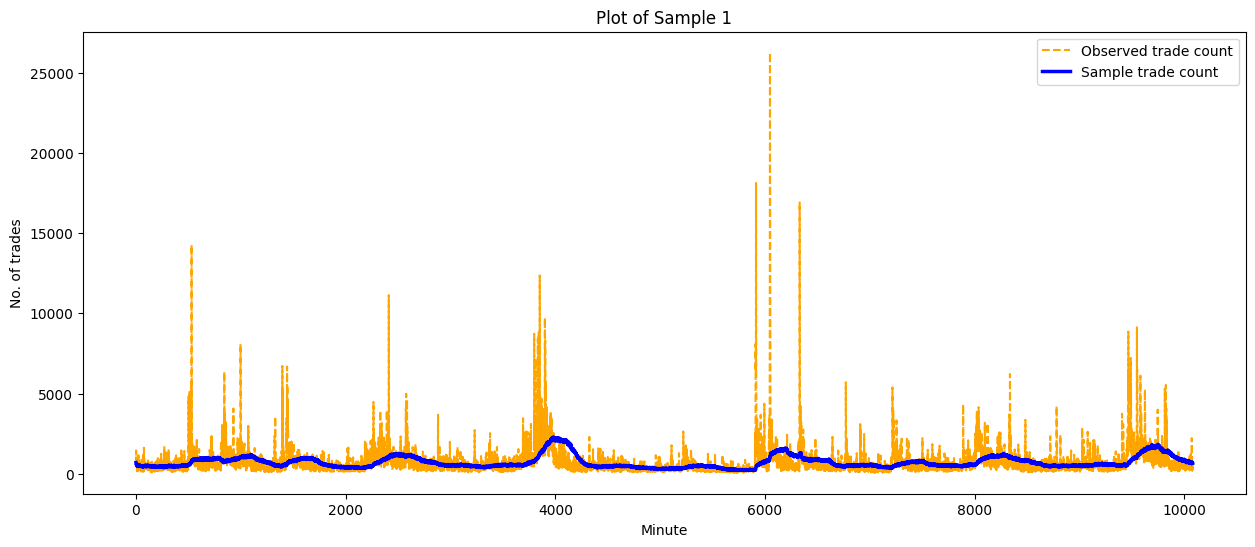

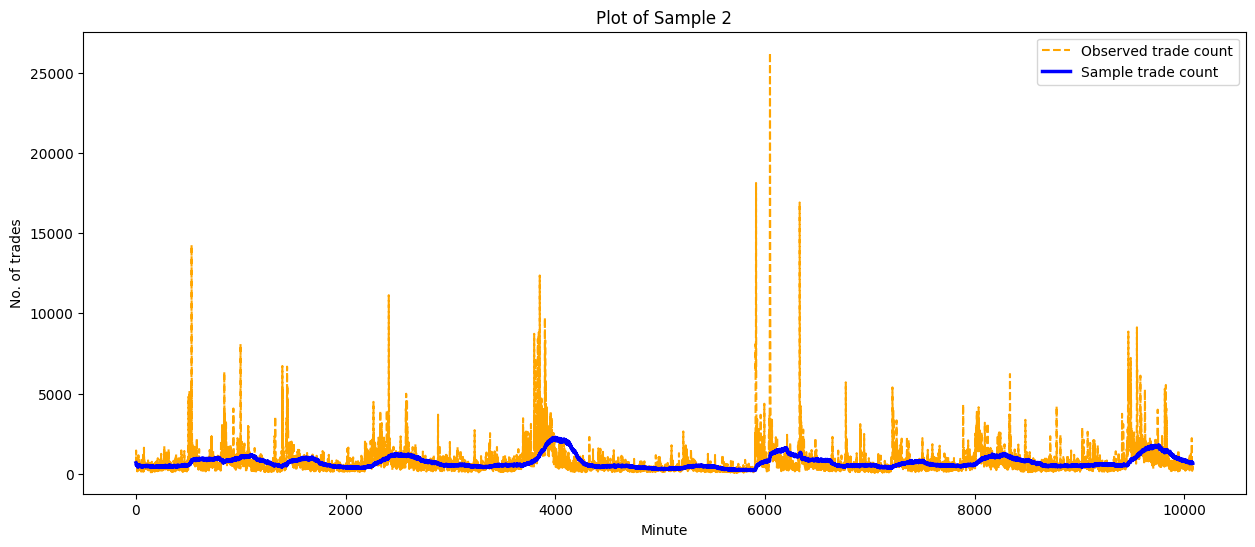

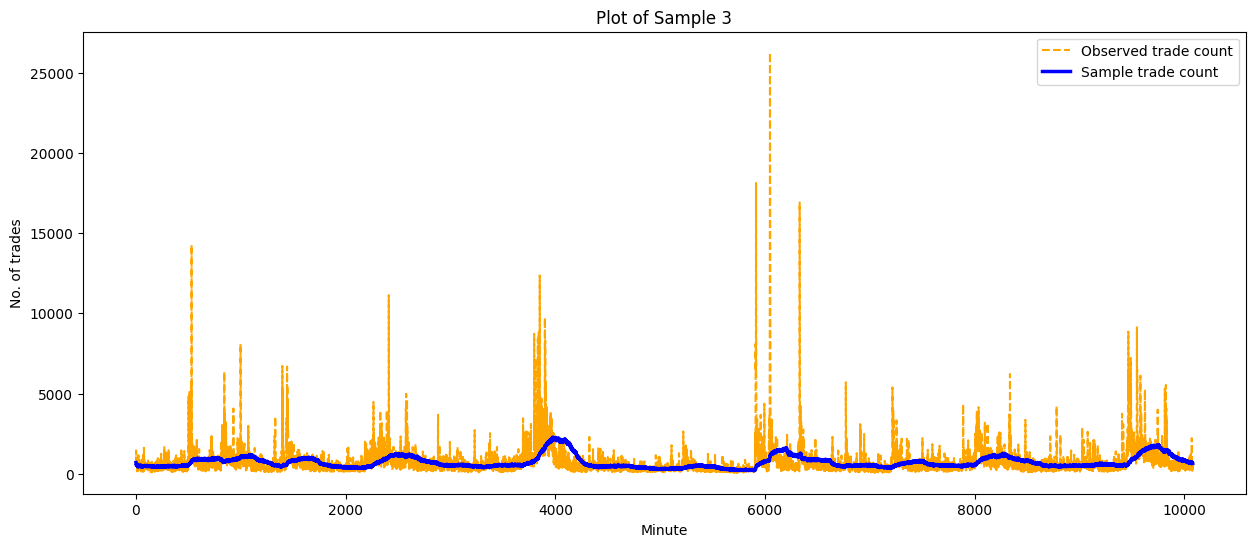

In [10]:
def plot_samples(samples, df):
  i = 1
  for sample in samples:
    plt.figure(figsize=(15, 6))
    plt.xlabel("Minute")
    plt.ylabel("No. of trades")

    plt.plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    plt.plot(sample, color="blue", linewidth=2.5, label="Sample trade count")

    plt.legend()
    plt.title(f"Plot of Sample {i}")
    plt.show()
    i += 1

gp = Gamma_Poisson(1, 1, 300, df)
gp.generate_posterior()
np.random.seed(42)
samples = gen_samples(gp.params, 3)
plot_samples(samples, df)


In [11]:
def check_ppi_validity(gp, alpha):
  df = gp.df
  df = df.sort_values(by="timestamp").reset_index(drop=True)
  array = df["trade_count"].tolist()
  cnt = 0
  gp.generate_posterior()
  gp.generate_ppi(alpha)

  for i in range(len(array)):
    if array[i] < gp.ppi[alpha]["lower_bound"][i] or array[i] > gp.ppi[alpha]["upper_bound"][i]:
      cnt += 1
      
  return cnt

table = []
for lag in ([float("inf"), 400, 300, 250, 200, 150, 100, 50, 10]):
    sub = []
    sub.append(lag)
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    val = check_ppi_validity(gp, 0.95)
    sub.append(val)
    sub.append(100 * val / len(gp.df))
    table.append(sub)

print(tabulate(table, headers = ["Lag", "Count", "Percentage"]))

  Lag    Count    Percentage
-----  -------  ------------
  inf     9368       92.9273
  400     9210       91.36
  300     9155       90.8144
  250     9130       90.5664
  200     9043       89.7034
  150     8984       89.1181
  100     8953       88.8106
   50     8834       87.6302
   10     8490       84.2178
